# Logistic model fitting using Sequential Monte Carlo

This example illustrates how to use SMC to sample from a posterior distribution for the logistic model, with normal errors. This example also indicates how it is typically necessary to tune hyperparameters to ensure good algorithmic performance on a given problem.

In [1]:
import os
os.chdir('../')
from __future__ import print_function
import pints
import pints.toy as toy
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

# Load a forward model
model = toy.LogisticModel()

# Create some toy data
real_parameters = [0.015, 500]
times = np.linspace(0, 1000, 1000)
org_values = model.simulate(real_parameters, times)

# Add noise
noise = 10
values = org_values + np.random.normal(0, noise, org_values.shape)
real_parameters = np.array(real_parameters + [noise])

# Get properties of the noise sample
noise_sample_mean = np.mean(values - org_values)
noise_sample_std = np.std(values - org_values)

# Create an object with links to the model and time series
problem = pints.SingleOutputProblem(model, times, values)

# Create a log-likelihood function (adds an extra parameter!)
log_likelihood = pints.UnknownNoiseLogLikelihood(problem)

# Create a uniform prior over both the parameters and the new noise variable
log_prior = pints.UniformLogPrior(
    [-5, 400, noise*0.1],
    [5, 600, noise*100]
)

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)

# Select mean and variance matrix of initial proposal dist
x0 = [0.015,500,10]

# Create mcmc routine
sampler = pints.SMC(log_posterior, x0, sigma0=[[  2.91011771e-10,  -2.36999772e-06,   3.10373379e-07],
       [ -2.36999772e-06,   2.01671027e-01,  -7.21897714e-03],
       [  3.10373379e-07,  -7.21897714e-03,   2.98319257e-02]])

# Set number of particles
sampler.set_particles(5000)

# Run sampler
samples = sampler.run()

Running sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Resampling at end of each iteration
Number of MCMC steps at each temperature: 1
Sampling from distribution of temperature: 0.000278255940221
Sampling from distribution of temperature: 0.000774263682681
Sampling from distribution of temperature: 0.00215443469003
Sampling from distribution of temperature: 0.00599484250319
Sampling from distribution of temperature: 0.016681005372
Sampling from distribution of temperature: 0.0464158883361
Sampling from distribution of temperature: 0.129154966501
Sampling from distribution of temperature: 0.35938136638
Sampling from distribution of temperature: 1.0


## Poor performance with default hyperparameters

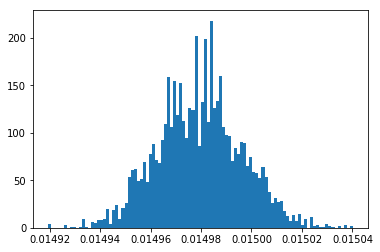

1383.35951074


In [2]:
plt.hist(samples[:, 0],100)
plt.show()
print(sampler.ess())

## Change resampling threshold and also turn off resampling at the end of the algorithm

In [3]:
# Don't resample at end of steps 2 and 3 in Del Moral et al. (2006) Algorithm 3.1.1
sampler.set_resample_end_2_3(False)

# Set ESS resampling threshold (essentially we never resample with this threshold)
sampler.set_ess_threshold(5)

# Run sampler
samples = sampler.run()

Running sequential Monte Carlo
Total number of particles: 5000
Number of temperatures: 10
Not resampling at end of each iteration
Number of MCMC steps at each temperature: 1
Sampling from distribution of temperature: 0.000278255940221
Sampling from distribution of temperature: 0.000774263682681
Sampling from distribution of temperature: 0.00215443469003
Sampling from distribution of temperature: 0.00599484250319
Sampling from distribution of temperature: 0.016681005372
Sampling from distribution of temperature: 0.0464158883361
Sampling from distribution of temperature: 0.129154966501
Sampling from distribution of temperature: 0.35938136638
Sampling from distribution of temperature: 1.0


## Now does much better

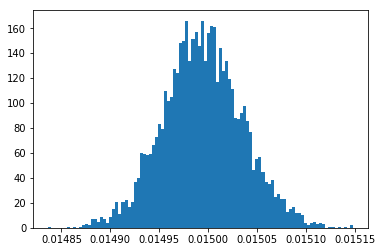

593.644612473


In [4]:
plt.hist(samples[:, 0], 100)
plt.show()
print(sampler.ess())